## Import Libraries

In [141]:
import re
import os
import random
import pickle
from collections import deque

import itertools
from itertools import chain
from tqdm import tqdm_notebook
from IPython.display import clear_output

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Read data files

In [48]:
def read_file(ticker):
    with open('/Users/samhsia/NCCU/碩論/Code/Paper/Data/Combine_pkl/{}_combine.pickle'.format(ticker), 'rb') as file:
        combine_data = pickle.load(file) # combine_data -> in defaultdict(list) type

    return combine_data

## Reconstrct the training data

```
Step1. 以過去 k 個交易日為 input sequence。
Step2. 將 input sequence 的 title concatenate，並結合 target 建構 DataFrame object。
```

In [123]:
def reconstruct(combine_dict, train_days):
    news_to_train = []
    target_y = []
    date = []
    del_index = []
    
    for key, value in combine_dict.items():
        try:
            target = value[1]
            news = value[2:]
            
            if isinstance(target, int):
                date.append(key)
                news_to_train.append(news)
                target_y.append(target)
        
        except:
            del_index.append(key)

    # 移除有新聞但沒有交易的日期
    for key in del_index:
        combine_dict.pop(key, None)     
    
    # 以 n 個交易日為 input sequence -> 使用 deque (可限制長度的 list)
    SEQ_LEN = train_days
    prev_news = deque(maxlen=SEQ_LEN)
    
    news_seperate_ndays = []
    for idx, news in enumerate(news_to_train):
        prev_news.append(news)
        if len(prev_news) == SEQ_LEN:
            n_days_news = list(prev_news)
            n_days_news_1d = list(itertools.chain.from_iterable(n_days_news))
            news_seperate_ndays.append(n_days_news_1d)
    
    x = news_seperate_ndays
    y = target_y[train_days-1:]
    date = date[train_days-1:]
    
    assert len(x) == len(y)
    assert len(x) == len(date)

    return date, x, y

---------------------------------------------------------

## Form the dataframe for training BERT

In [124]:
def to_train_test_df(x, y, date, ticker):
    news_df = pd.DataFrame({
        'date': date,
        'news': x,
        'target': y,
        'ticker': ticker
    })
    
    news_df = news_df.sort_values(by='date')
    news_df = news_df.set_index('date')
    news_df = news_df[:'2019-11-20']
    
    len_df = len(news_df)
    train_len = int(0.8*len_df)
    
    # 0.8 for training, 0.2 for testing
    train_df = news_df.iloc[:train_len, :]
    test_df = news_df.iloc[train_len:, :]
    
    return train_df, test_df

In [125]:
# the element in news columns is stored in list type -> change to str and concatenate
def from_list_to_str(x):
    try:
        return " ".join(x)
    
    except:
        return x

In [135]:
if __name__ == '__main__':
    tickers = ['Amazon', 'Apple', 'Google', 'J&J', 'JPMorgan', 'Microsoft', 'Visa']

    train_df = pd.DataFrame({})
    test_df = pd.DataFrame({})

    for tick in tqdm_notebook(tickers):
        combine_data = read_file(tick)   # read files
        date, x, y = reconstruct(combine_data, train_days=5)  # reconstruct input, target

        tick_train_df, tick_test_df = to_train_test_df(x, y, date, tick) # to dataframe
        
        # concatenate all dataframes
        train_df = pd.concat([train_df, tick_train_df], axis=0)
        test_df = pd.concat([test_df, tick_test_df], axis=0)
        
    # change list to str and concatenate
    train_df.news = train_df.news.apply(from_list_to_str)
    test_df.news = test_df.news.apply(from_list_to_str)
    
    # sort the dataframe by date
    train_df = train_df.sort_values(by='date')
    test_df = test_df.sort_values(by='date')

    
    # change directory
    
    # save it to pickle files
    with open(r'/Users/samhsia/NCCU/碩論/Code/Paper/Data/BERT/Bert_train_5days.pickle', 'wb') as train_file:
        pickle.dump(train_df, train_file)
    
    with open(r'/Users/samhsia/NCCU/碩論/Code/Paper/Data/BERT/Bert_test_5days.pickle', 'wb') as test_file:
        pickle.dump(test_df, test_file)

Text(0.5, 1.0, 'Movement of the stock return')

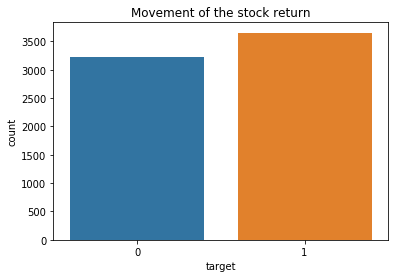

In [147]:
sns.countplot(train_df['target'])
plt.title('Movement of the stock return')

Text(0.5, 1.0, 'Movement of the stock return')

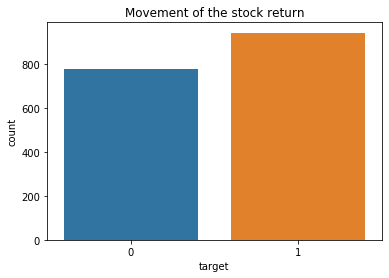

In [148]:
sns.countplot(test_df['target'])
plt.title('Movement of the stock return')

In [140]:
pd.value_counts(train_df['target'])

1    3653
0    3221
Name: target, dtype: int64

In [138]:
pd.value_counts(test_df['target'])

1    944
0    778
Name: target, dtype: int64